In [28]:
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr

Populating the interactive namespace from numpy and matplotlib


In [29]:
rotor = vsr.Biv(pi/6,0,0).exp()
vectors_a = [vsr.Vec(1,0,0), vsr.Vec(0,1,0), vsr.Vec(0,0,1)]
vectors_b = [a.spin(rotor) for a in vectors_a]

In [30]:
rotor1 = vsr.Biv(0,pi/6,0).exp()

# Result

In [31]:
def cost(a,b,R):
    r = (a.spin(R) - b)
    return (r * r * 0.5)[0]

In [32]:
cost(vectors_a[0], vectors_b[0], rotor1)

0.7499999999999999

## Jacobian

In [33]:
def jacobian34(a,b,R):
    
    def J(Ei,a,b,R):
        Ei = vsr.EGA(Ei)
        a = vsr.EGA(a)
        b = vsr.EGA(b)
        R = vsr.EGA(R)
        return Ei * a * R.rev() + R * a * Ei.rev()

    JR = np.zeros((3,4))
    JR[:,0] = np.array(J(vsr.Rot(1,0,0,0),a,b,R))[1:4]
    JR[:,1] = np.array(J(vsr.Rot(0,1,0,0),a,b,R))[1:4]
    JR[:,2] = np.array(J(vsr.Rot(0,0,1,0),a,b,R))[1:4]
    JR[:,3] = np.array(J(vsr.Rot(0,0,0,1),a,b,R))[1:4]
    return JR

In [34]:
J34 = jacobian34(vectors_a[0], vectors_b[0], rotor1)
print(J34)

[[ 1.7321  0.      1.      0.    ]
 [ 0.     -1.7321  0.      1.    ]
 [ 1.      0.     -1.7321  0.    ]]


In [35]:
def jacobian43(R):
    JB = np.zeros((4,3))
    JB[:,0] = np.array(vsr.Biv(1,0,0) * R)
    JB[:,1] = np.array(vsr.Biv(0,1,0) * R)
    JB[:,2] = np.array(vsr.Biv(0,0,1) * R)
    return JB

In [36]:
J43 = jacobian43(rotor1)
print(J43)

[[ 0.     0.5    0.   ]
 [ 0.866  0.    -0.5  ]
 [ 0.     0.866  0.   ]
 [ 0.5    0.     0.866]]


In [94]:
def jacobian(a,b,rot):
    return np.dot(jacobian34(a,b,rot), jacobian43(rot))

In [109]:
J = jacobian(vectors_a[0], vectors_b[0], rotor1)
print(np.dot(J.T,J))

[[ 1.      0.     -1.7321]
 [ 0.      4.      0.    ]
 [-1.7321  0.      3.    ]]


In [116]:
Hess(vectors_a[0], vectors_b[0], rotor1)

array([[ 1.   ,  1.5  , -0.866],
       [ 1.5  ,  1.   ,  0.866],
       [-0.866,  0.866,  0.   ]])

In [115]:
def Hi(B,a,b,R):
    G = B.comm(a.spin(R)) * 2
    H = (a.spin(R) - b) * ((B * B * a.spin(R)) + 
                           2.0 * a.spin(R).spin(B) + (a.spin(R) * B * B))
    ans = H + G * G.rev()
#     ans = G * G
#     ans = H
    return ans

In [105]:
r1 = vsr.EGA(rotor1)
Hi(vsr.EGA(vsr.Biv(1,0,0) )* r1, vsr.EGA(vectors_a[0]), vsr.EGA(vectors_b[0]), r1)[0]

3.8459253727671276e-16

In [106]:
def res(a,b,rot):
    return np.array((a.spin(rot) - b))

In [107]:
def cost(a,b,rot):
    r = res(a,b,rot)
    return (r * r * 0.5)[0]

In [108]:
def Hess(a,b,rot):
    a = vsr.EGA(a)
    b = vsr.EGA(b)
    R = vsr.EGA(rot)
    E12 = vsr.EGA(vsr.Biv(1,0,0))
    E13 = vsr.EGA(vsr.Biv(0,1,0))
    E23 = vsr.EGA(vsr.Biv(0,0,1))
    H12 = Hi(E12,a,b,R) 
    H13 = Hi(E13,a,b,R)  
    H23 = Hi(E23,a,b,R)  
    H1213 = 0.25 * (Hi(E12+E13,a,b,R) - Hi(E12-E13,a,b,R))
    H1223 = 0.25 * (Hi(E12+E23,a,b,R) - Hi(E12-E23,a,b,R))
    H1323 = 0.25 * (Hi(E13+E23,a,b,R) - Hi(E13-E23,a,b,R))
    return np.array([[  H12[0], H1213[0], H1223[0]],
                     [H1213[0],   H13[0], H1323[0]],
                     [H1223[0], H1323[0],   H23[0]]])

In [18]:
def grad(a,b,R):
    a = vsr.EGA(a)
    b = vsr.EGA(b)
    R = vsr.EGA(R)
    E12 = vsr.EGA(vsr.Biv(1,0,0)) 
    E13 = vsr.EGA(vsr.Biv(0,1,0))
    E23 = vsr.EGA(vsr.Biv(0,0,1)) 
    d = lambda Ei : ((a.spin(R) - b) * (2 * Ei.comm(a.spin(R))))[0]
    return np.array([d(E12), d(E13), d(E23)])

In [19]:
np.sum([grad(a,b, rotor1) for a,b in zip(vectors_a, vectors_b)], axis=0)

array([ 2.5981, -2.5981, -1.5   ])

In [20]:
np.sum([Hess(a,b, rotor1) for a,b in zip(vectors_a[:1], vectors_b[:1])], axis=0)

array([[ 1.   ,  1.5  , -0.866],
       [ 1.5  ,  1.   ,  0.866],
       [-0.866,  0.866,  0.   ]])

In [21]:
np.dot(jacobians.T, jacobians)

NameError: name 'jacobians' is not defined

In [263]:
np.dot(jacobians.T,residuals)

array([[ 2.5981],
       [-2.5981],
       [-1.5   ]])

In [264]:
residuals = np.array([res(a,b,rotor1) for a,b in zip(vectors_a, vectors_b)]).reshape(-1,1)
residuals

array([[ 0.   ],
       [-0.866],
       [ 0.866],
       [ 0.866],
       [ 0.5  ],
       [ 0.   ],
       [-0.866],
       [ 0.   ],
       [-0.5  ]])

In [265]:
np.dot(residuals.T,residuals)[0,0]

3.4999999999999991

In [22]:
jacobians = np.array([jacobian(a,b,rotor1) for a,b in zip(vectors_a, vectors_b)]).reshape(-1,3)
jacobians

array([[ 0.    ,  1.7321,  0.    ],
       [-1.    ,  0.    ,  1.7321],
       [ 0.    , -1.    ,  0.    ],
       [ 2.    ,  0.    ,  0.    ],
       [ 0.    , -0.    ,  0.    ],
       [-0.    ,  0.    , -2.    ],
       [ 0.    ,  1.    ,  0.    ],
       [ 1.7321,  0.    ,  1.    ],
       [ 0.    ,  1.7321,  0.    ]])

4.44872438582
0.315836906325
0.00261964356127
2.78956656087e-09
3


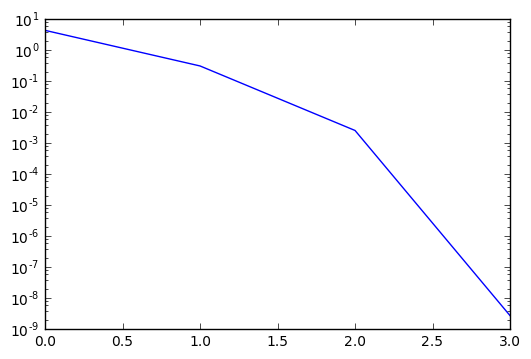

In [23]:
n_points=3
vectors_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)) for i in range(n_points)]
vectors_b = [vector.spin(rotor) for vector in vectors_a]

def update(rot):
    residuals = np.array([res(a,b,rot) for a,b in zip(vectors_a, vectors_b)]).reshape(-1,1)
    cost = np.dot(residuals.T,residuals)[0,0]    
    jacobians = np.array([jacobian(a,b,rot) for a,b in zip(vectors_a, vectors_b)]).reshape(-1,3)
    
    g = np.dot(jacobians.T, residuals)
    H = np.dot(jacobians.T, jacobians)

#     g = np.sum([grad(a,b, rot) for a,b in zip(vectors_a, vectors_b)], axis=0)
#     H = np.sum([Hess(a,b, rot) for a,b in zip(vectors_a, vectors_b)], axis=0)
#     print(H)

    B = np.dot(np.linalg.pinv(H), g)
    rot = vsr.Biv(*B).exp() * rot
    grad_norm = np.linalg.norm(g)
    return rot, cost, grad_norm

rot = vsr.Rot(1,0,0,0)
ress = []
for i in range(10):
    rot, cost, grad_norm = update(rot)
    ress.append(cost)
    print(cost)
    if cost < 1e-6: 
        break
print(i)

semilogy(ress)

In [24]:
class MotorOptimizer(object):
    def __init__(self):
        self._motor_id = vsr.Mot(1,0,0,0,0,0,0,0)
        self._motor = vsr.Vec(1,2,3).trs() * vsr.Biv(pi/6,0,0).exp()
    
    def dataset(self):
        n_points = 10
        sigma = 0.09
        points_a = [(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null(),
                     vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
                    for i in range(n_points)]

        points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                           vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                          for a,b in points_a]

        lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
        lines_b = [line.spin(self._motor) for line in lines_a]
        return lines_a, lines_b
    
    def _jacobian86(self, M):
        J = np.zeros((8,6))
        J[:,0] = np.array(vsr.Dll(1,0,0,0,0,0) * M)
        J[:,1] = np.array(vsr.Dll(0,1,0,0,0,0) * M)
        J[:,2] = np.array(vsr.Dll(0,0,1,0,0,0) * M)
        J[:,3] = np.array(vsr.Dll(0,0,0,1,0,0) * M)
        J[:,4] = np.array(vsr.Dll(0,0,0,0,1,0) * M)
        J[:,5] = np.array(vsr.Dll(0,0,0,0,0,1) * M)
        return J
    
    def _jacobian68(self,a,b,M):
        
        def Ji(Ei,a,b,M):
            Ei = vsr.CGA(Ei)
            a = vsr.CGA(a)
            b = vsr.CGA(b)
            M = vsr.CGA(M)
            return Ei * a * M.rev() + M * a * Ei.rev()
        
        def to_mot(a):
            return np.array([a[6], a[7], a[8], a[12], a[13], a[14]])

        J = np.zeros((6,8))
        J[:,0] = to_mot(Ji(vsr.Mot(1,0,0,0,0,0,0,0),a,b,M))
        J[:,1] = to_mot(Ji(vsr.Mot(0,1,0,0,0,0,0,0),a,b,M))
        J[:,2] = to_mot(Ji(vsr.Mot(0,0,1,0,0,0,0,0),a,b,M))
        J[:,3] = to_mot(Ji(vsr.Mot(0,0,0,1,0,0,0,0),a,b,M))
        J[:,4] = to_mot(Ji(vsr.Mot(0,0,0,0,1,0,0,0),a,b,M))
        J[:,5] = to_mot(Ji(vsr.Mot(0,0,0,0,0,1,0,0),a,b,M))
        J[:,6] = to_mot(Ji(vsr.Mot(0,0,0,0,0,0,1,0),a,b,M))
        J[:,7] = to_mot(Ji(vsr.Mot(0,0,0,0,0,0,0,1),a,b,M))
        return J
        
    def jacobian(self, a, b, M):
        return np.dot(self._jacobian68(a,b,M), self._jacobian86(M))
    
    def res(self,a,b,M):
        return np.array((a.spin(M) - b))
    
    def grad(self, a, b, M):
        return np.dot(self.jacobian(a,b,M).T,self.res(a,b,M))
    
    def JtJ(self, a, b, M):
        J = self.jacobian(a,b,M)
        return np.dot(J.T,J)
    
    def update(self,vectors_a, vectors_b, M):
        residuals = np.array([self.res(a,b,M) 
                              for a,b in zip(vectors_a, vectors_b)]).reshape(-1,1)
        cost = np.dot(residuals.T,residuals)[0,0]    
        jacobians = np.array([self.jacobian(a,b,M) 
                              for a,b in zip(vectors_a, vectors_b)]).reshape(-1,6)

        g = np.dot(jacobians.T, residuals)
        H = np.dot(jacobians.T, jacobians)

        B = np.dot(np.linalg.pinv(H), -g)
        M = vsr.Dll(*B).exp() * M
        grad_norm = np.linalg.norm(g)
        return M, cost, grad_norm

In [25]:
mo = MotorOptimizer()
mot = mo._motor_id
a,b = mo.dataset()

In [26]:
mo.grad(a[0], b[0], mot)

array([ 2.6683,  2.1862, -0.255 ,  0.3151, -0.8209,  2.922 ])

101.610020659
23.6904932701
3.14463819408
0.0263639995766
9.66121583484e-07
4


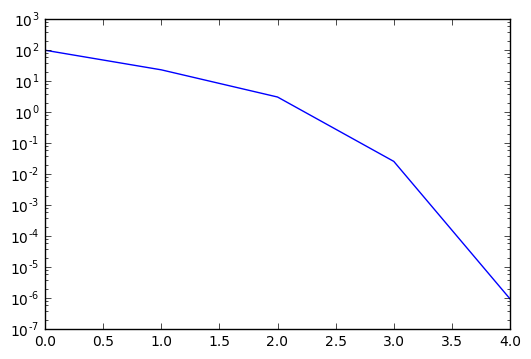

In [27]:
ress = []
for i in range(10):
    mot, cost, grad_norm = mo.update(a,b,mot)
    ress.append(cost)
    print(cost)
    if cost < 1e-6: 
        break
print(i)

semilogy(ress)

In [445]:
print(mo.grad(a[0], b[0], mo._motor_id))

[ 3.9184 -1.9114  0.7441  0.802  -0.3787  3.096 ]


In [446]:
def grad_lines(a,b,R):
    a = vsr.CGA(a)
    b = vsr.CGA(b)
    R = vsr.CGA(R)
    E12 = vsr.CGA(vsr.Dll(1,0,0,0,0,0)) 
    E13 = vsr.CGA(vsr.Dll(0,1,0,0,0,0))
    E23 = vsr.CGA(vsr.Dll(0,0,1,0,0,0)) 
    E1i = vsr.CGA(vsr.Dll(0,0,0,1,0,0)) 
    E2i = vsr.CGA(vsr.Dll(0,0,0,0,1,0)) 
    E3i = vsr.CGA(vsr.Dll(0,0,0,0,0,1)) 
    d = lambda Ei : ((a.spin(R) - b) * (2 * Ei.comm(a.spin(R))))[0]
    return np.array([d(E12), d(E13), d(E23), d(E1i), d(E2i), d(E3i)])

In [455]:
(a[0].spin(R) - b[0]) * vsr.Dll(1,0,0,0,0,0).comm(a[0]) * 2

TypeError: spin(): incompatible function arguments. The following argument types are supported:
    1. (self: versor_pybind11.Dll, arg0: vsr::Multivector<vsr::algebra<vsr::metric<4, 1, true>, double>, vsr::Basis<(short)0, (short)3, (short)5, (short)6, (short)17, (short)18, (short)20, (short)23> >) -> versor_pybind11.Dll

Invoked with: Dll: [ -0.1711 -0.4537 0.8746 -0.2019 0.3204 -0.1823 ], CGA: [ 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]

In [425]:
a[0].drv().vec()

Vec: [ -0.39 0.49 -0.95 ]

Dll: [ 0 -0.6088 -0.7716 -3.059 1.185 0.6897 ]

In [439]:
ad,bd = mo.dataset()
a = vsr.CGA(ad[0])
b = vsr.CGA(bd[0])
R = vsr.CGA(mo._motor_id)
E12 = vsr.CGA(vsr.Dll(1,0,0,0,0,0)) 
d = lambda Ei : ((a.spin(R) - b) * (2 * Ei.comm(a.spin(R))))
d(E12)

CGA: [ -1.6 0 0 0 0 0 0.9 0 0 0 0 0 1.7 1.2 5.1 0 0 0 0 0 0 0 0 0 0 0 0 3.4 0 0 0 0 ]

In [440]:
Hi(E12,a,b,R)

CGA: [ -1.8 0 0 0 0 0 3.1 0 0 0 0 0 2.3 -3.4 6.8 0 0 0 0 0 0 0 0 0 0 0 0 -11 0 0 0 0 ]

In [ ]:
def grad(a,b,R):
    a = vsr.CGA(a)
    b = vsr.CGA(b)
    R = vsr.CGA(R)
    E12 = vsr.EGA(vsr.Biv(1,0,0)) 
    E13 = vsr.EGA(vsr.Biv(0,1,0))
    E23 = vsr.EGA(vsr.Biv(0,0,1)) 
    d = lambda Ei : ((a.spin(R) - b) * (2 * Ei.comm(a.spin(R))))[0]
    return np.array([d(E12), d(E13), d(E23)])